In [2]:
# Import all neccesary python libraries for analysis.
import pymc as pm
import pandas as pd
import pyreadr
import nutpie
import arviz as az
import matplotlib.pyplot as plt
import numpy as np 

# Overview
Meta analysis is a critical statistical method within any analysts toolkit an “analysis of analyses” (Glass 1976) if you will. What Glass is pointing out is that unit of analysis in meta-analysis are the results of analyses. This analysis here is an example of the a simple application of meta-analysis where the analysis of analyses is specifcally directed at the analysis of effect size estimates from the group of analyses.

 The following meta-analysis is a Bayesian hierchial model (the basis of basic Bayeisan meta analysis) generated using the PyMC PPL framework and the associated Rust based nutpie Hamiltonian monte Carlo sampler. The basis for this analysis is from Harrer et al. (2021) where analysis was conducted using R and the brms package.

 ## The data

 The data analysed here has been downloaded from the [dmetar github](https://github.com/MathiasHarrer/dmetar/blob/master/data/ThirdWave.rda) and is called the Thirdwave data set. This dataset is a collection of studies of third wave psychotherapies effect on the percieved stress of college students. The dataset here comes pre-calculated measures of effects size which simplifies the process of the analysis demonstration here significantly. The specific effect size type analysed here is *Hedges' g* (Henceforth just mentioned as effect size estimates) and the assosciated standard error of the effect size estimates.

In [3]:
# Import rda file into OrderedDict.
keys = pyreadr.read_r("data/ThirdWave.rda")

# Extract from OrderedDict the pandas dataframes
df = keys["ThirdWave"]

# Convert author values to ctegroical codes
df['Author'] = pd.Categorical(df['Author'])
author_id = df['Author'].cat.codes

# Extract the data for analysis
seTE = df["seTE"]
TE = df["TE"]

# The Model and it priors

Following but updating the formula from the text to be more in line with the code, the model therefore is formulated as such.
\begin{align}
\hat\theta_k &\sim \mathcal{N}(\mu +\theta_k, \sigma_k) \notag \\
\theta_k &\sim \mathcal{N}(0,\tau) \notag \\
\mu &\sim \mathcal{N}(0,1) \notag \\
\tau &\sim \mathcal{HC}(0,0.5) \tag{13.5} \\
\end{align}

How were the priors for this model selected? To start it is important to point a common reality when conducting any meta-analysis. That reality being that you are highly likely to face the common issues related to small sample sizes. This is the case here, as the dataset only has 18 data points. In small sample problems Bayesain methods shine but the selection of priors in such situations becomes even more critical. Without a bespoke prior setting routine for the analysis a good general approach is to use weakly informative priors (Williams et al. 2018). As such in meta-analysis we can make general reasonable suggestion for priors.  In the case of $mu$ the $\mu \sim \mathcal{N}(0,1)$ is a reasonable prior as getting effect size for behavioural research above 2 or less than -2 is extremely rare. Setting the $\tau$ parameter is a liitle more difficult as we must meet $\tau > 0$ as Willaims et al. noted commonly applied prior probability distribution is the HalfCauchy distribution and $\tau \sim \mathcal{HC}(0,0.5)$, because in many meta analsysis the $\tau$ value is .3 we can cover this with a more conservative value by using .5 as it provides a much flatter distribution. 

<img src="https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/Doing_Meta_Analysis_in_R_files/figure-html/unnamed-chunk-432-1.png" alt="Meta-Analysis Example Image" />
Figure taken from Harrer et al. 2021

In [4]:
coords = {"Author": np.unique(df["Author"])}

# Generate pymc Bayesian Hierachial model.
with pm.Model(coords=coords) as model:
    
    SMD = pm.Normal("SMD", mu = 0, sigma = 1)
    tau = pm.HalfCauchy("tau", beta=.5)
    # Random intercepts
    theta = pm.Normal('theta', mu=0, sigma = tau, dims="Author")
    # Get individuasla study effects
    ind = pm.Deterministic("Study estimates", SMD + theta[author_id], dims="Author") 
    y = pm.Normal("y", mu = ind, sigma = seTE, observed=TE)
   

In [25]:
# Compile nutpie sampler pymc model.
compiled_model = nutpie.compile_pymc_model(model)
trace = nutpie.sample(compiled_model)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.58,7
,1300,0,0.62,7
,1300,0,0.57,15
,1300,0,0.63,7
,1300,0,0.56,7
,1300,0,0.61,15


In [26]:
# Sample from the posterior predictive distribution.
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y]


/home/harrison/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [27]:
# Get the results of the model MCMC samples.
az.summary(trace, var_names=["tau", "SMD"], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.292,0.102,0.069,0.468,0.004,0.003,648.0,265.0,1.01
SMD,0.570,0.094,0.385,0.751,0.002,0.002,1689.0,2533.0,1.00


## Trace plots

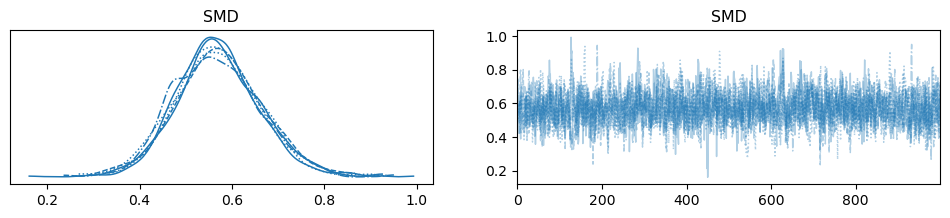

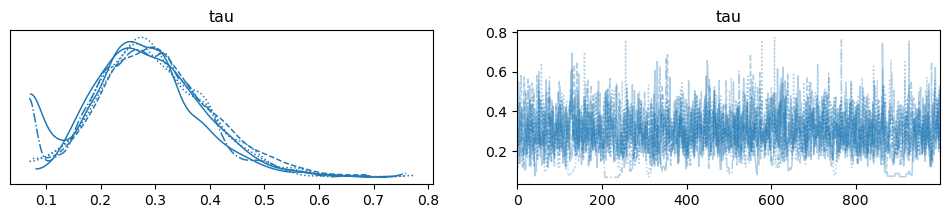

In [28]:
# plot using arviz the trace of MCMC samples.
az.plot_trace(trace, var_names="SMD");
az.plot_trace(trace, var_names="tau");

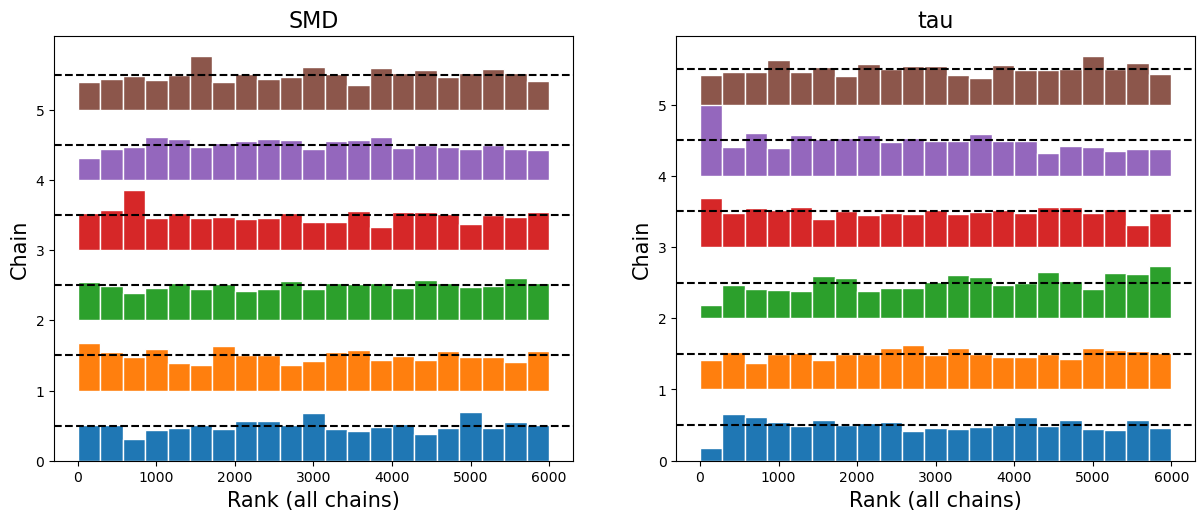

In [29]:
# Rank plot of MCMC chains.
az.plot_rank(trace, var_names=["SMD", "tau"]);

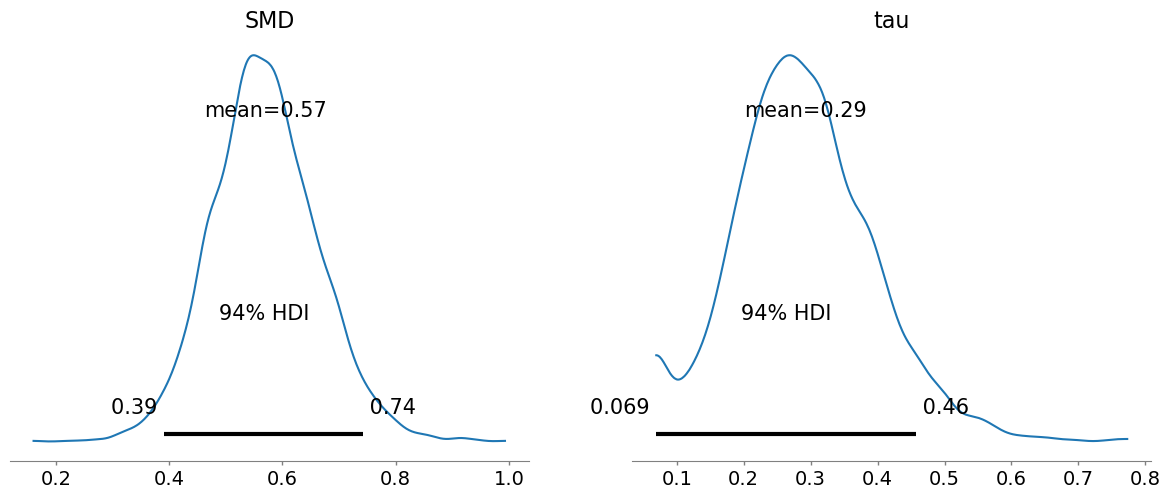

In [30]:
# plot posteriors
az.plot_posterior(trace,  var_names=["SMD", "tau"]);

## Posterior predictive check plot

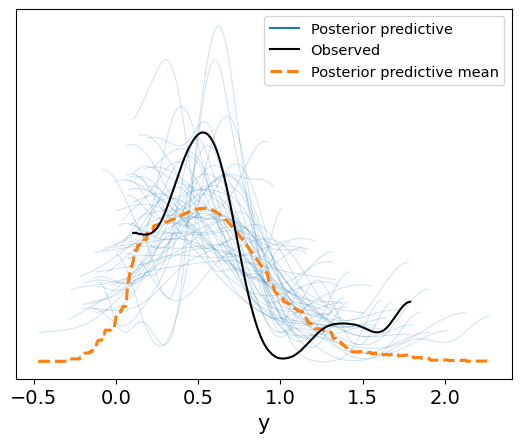

In [31]:
# To coincide with brms output in Harner et al. 
# smaller number of pp samples used than default.
az.plot_ppc(trace, num_pp_samples=50);

# Interpreting model results

The between study heterogenity has been estimated $\tau$ = .29, CI [0.10, 0.49]. The fixed population effect $\mu$ = .57, CI [0.39, 0.76] as formulated within our model specification. Recalling that the dependent variable was an effect size measure the reuslt of the analysis then suggest that psychotherpay interventions had a moderate effect becuase this is a Bayesian analysis we are not constrained to frame the results in terms of a Null hypotheis signifcane test. However, we would benefit from visualisations of the continous nature of the measures of effect estimated from the model.  

## Posterior plots

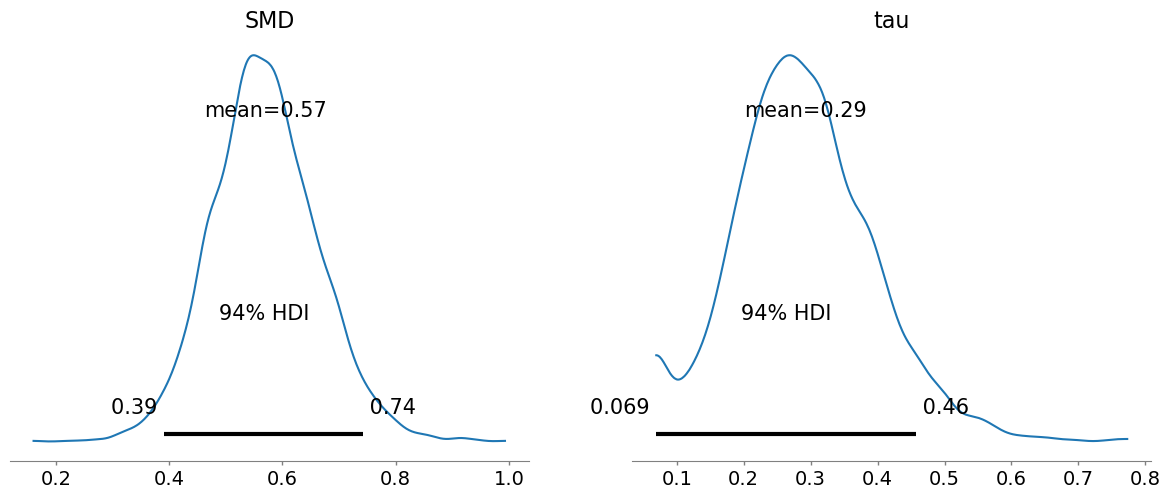

In [32]:
az.plot_posterior(trace,  var_names=["SMD", "tau"]);

# Empirical cumulative distribution function (ECDF) plot 

/home/harrison/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/ecdfplot.py:295: BehaviourChangeWarning: In future versions, if `eval_points` is not provided, then the ECDF will be evaluated at the unique values of the sample. To keep the current behavior, provide `eval_points` explicitly.
  warnings.warn(


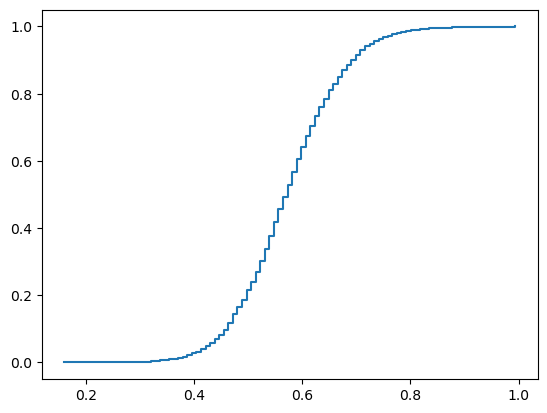

In [33]:
# Plot empirical cumulative distributing function.
az.plot_ecdf(trace.posterior.SMD);

As the posterior plots ECDF plot above shows There very low probabilty for values of effect sizes below ,4 

# Forest plot

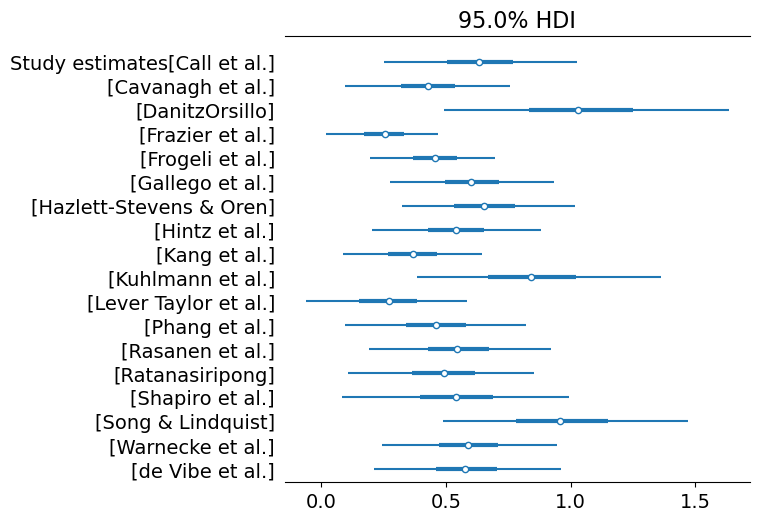

In [34]:
# Plot a arviz forest plot.
az.plot_forest(trace, var_names="Study estimates", combined= True, hdi_prob=.95);

# References
Glass, Gene V. 1976. “Primary, Secondary, and Meta-Analysis of Research.” Educational Researcher 5 (10): 3–8.

Harrer, M., Cuijpers, P., Furukawa, T.A., & Ebert, D.D. (2021). Doing Meta-Analysis with R: A Hands-On Guide. Boca Raton, FL and London: Chapmann & Hall/CRC Press. ISBN 978-0-367-61007-4.

Williams, D. R., Rast, P., & Bürkner, P. C. (2018). Bayesian meta-analysis with weakly informative prior distributions.